## Import modules and functions

In [1]:
import numpy as np
import os
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import scipy.ndimage as ndi
from skimage.filters import rank 
from scipy.signal import butter, lfilter
import scipy.misc as misc
from skimage import exposure
from PIL import Image
import colorcet as cc
from scipy.misc import toimage
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns
from scipy import stats
import cv2
from pyspark import SparkContext, SparkConf
import skimage
from pathlib import Path
%matplotlib inline
def mean2(x):
    y = np.sum(x) / np.size(x);
    return y
def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r
from copy import deepcopy
from skimage.filters import threshold_otsu,threshold_li
import glob
from IPython.display import clear_output
import scipy.io as spio
import pims

## Specify experiment directory

In [2]:
expdir='/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed Culture/STEDBIN/'
protein="TNR" #TNR,Agg,WFA,HABP

## Make dictionary for results and load aligned images from Matlab GUI

In [3]:
#make synapse results dictionary

spots={"filename":[]}

path = os.path.dirname(expdir)  
outputFolder = os.path.dirname(expdir + "/new/")
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))      
for i in range(0,len(filelist)):
    if filelist[i].endswith(".txt"): 
        #if ("samecellonly" in str(filelist[i]))==False:
            if ("output_classification" in str(filelist[i]))==True:
                if (protein in str(filelist[i]))==True:
                     if ("backup" in str(filelist[i]))==False:
                        #if str(filelist[i][:-12]) not in str(spots["filename"]):
                            spots["filename"].append(filelist[i])


synapses_results={"spots classification filename":[],
                "sted spot":[],
                "vglut spot":[],
                "dio spot":[],
                "sted spot aligned":[],
                "vglut spot aligned":[],
                "dio spot aligned":[],
                 "sted spot aligned no back":[],
                "vglut spot aligned no back":[],
                "dio spot aligned no back":[],
                "Exp name":[],
                "Cell number":[],
                "unique id (expname_cell number)":[],
                "classification":[],
                  "mean ecm intensity sted":[],
                  "ecm intensity sted, bg subtracted":[],
                  "mean ecm intensity sted noback":[],
                  "ecm intensity sted noback bg subtracted":[],
                  "mean vglut intensity sted":[],
                  "vglut intensity sted, bg subtracted":[],
                  "mean vglut intensity sted noback":[],
                  "vglut intensity sted noback bg subtracted":[],
                  "mean vglut size (sum of pixels)":[],
                  "mean vglut size (sum of pixels) from noback":[],
                  "exp condition":[]}
                  
num=0
for spot in range(0,len(spots["filename"])):
    num+=1
    print(spots["filename"][spot])
    firstpart='/'.join(spots["filename"][spot].split("/")[:-1])
    lastpart=spots["filename"][spot].split("classification")[-1]
    synapses_results["spots classification filename"].append(spots["filename"][spot])
    file2read=firstpart+'/output_sted_'+lastpart
    synapses_results["sted spot"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    file2read=firstpart+'/output_homer_'+lastpart
    synapses_results["vglut spot"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    file2read=firstpart+'/output_dio_'+lastpart
    synapses_results["dio spot"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    file2read=firstpart+'/output_sted_aligned_'+lastpart
    synapses_results["sted spot aligned"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    file2read=firstpart+'/output_homer_aligned_'+lastpart
    synapses_results["vglut spot aligned"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    file2read=firstpart+'/output_dio_aligned_'+lastpart
    synapses_results["dio spot aligned"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    file2read=firstpart+'/output_sted_aligned_noback_'+lastpart
    synapses_results["sted spot aligned no back"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    file2read=firstpart+'/output_homer_aligned_noback_'+lastpart
    synapses_results["vglut spot aligned no back"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    file2read=firstpart+'/output_dio_aligned_noback_'+lastpart
    synapses_results["dio spot aligned no back"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    
    synapses_results["Exp name"].append(file2read.split("2019")[-1][0:4])
    synapses_results["Cell number"].append(lastpart[-9:-4])
    synapses_results["unique id (expname_cell number)"].append(file2read.split("2019")[-1][0:4]+'_'+lastpart[-9:-4])
    synapses_results["classification"].append(np.loadtxt(spots["filename"][spot]))
    synapses_results["exp condition"].append(synapses_results["spots classification filename"][spot].split("TIFs")[-1].split('/')[1])
    
    synapses_results["mean ecm intensity sted"].append(np.nan)
    
    synapses_results["ecm intensity sted, bg subtracted"].append(np.nan)
    
    synapses_results["mean ecm intensity sted noback"].append(np.nan)
    synapses_results["ecm intensity sted noback bg subtracted"].append(np.nan)
    
    synapses_results["mean vglut intensity sted"].append(np.nan)
    synapses_results["vglut intensity sted, bg subtracted"].append(np.nan)
    
    synapses_results["mean vglut intensity sted noback"].append(np.nan)
    synapses_results["vglut intensity sted noback bg subtracted"].append(np.nan)
    synapses_results["mean vglut size (sum of pixels)"].append(np.nan)
    synapses_results["mean vglut size (sum of pixels) from noback"].append(np.nan)
clear_output() 

## Tot. no. synapses read

In [4]:
len(synapses_results["spots classification filename"])

1620

## Make dictionary for individual synapse (spot) images

In [5]:
for spotno in range(0,len(synapses_results["spots classification filename"])):
    synapses_results["mean ecm intensity sted"][spotno]=np.nanmean(synapses_results["sted spot aligned"][spotno])
    synapses_results["mean ecm intensity sted noback"][spotno]=np.nanmean(synapses_results["sted spot aligned no back"][spotno])
    synapses_results["mean vglut intensity sted"][spotno]=np.nanmean(synapses_results["vglut spot aligned"][spotno])
    synapses_results["mean vglut intensity sted noback"][spotno]=np.nanmean(synapses_results["vglut spot aligned no back"][spotno])
    synapses_results["mean vglut size (sum of pixels)"][spotno]=np.sum(synapses_results["vglut spot aligned"][spotno])
    synapses_results["mean vglut size (sum of pixels) from noback"][spotno]=np.sum(synapses_results["vglut spot aligned no back"][spotno])

    #bg subtraction
    ecm_around_spot_bgsub=np.array(deepcopy(synapses_results["sted spot aligned"][spotno]))
    bg_ecm=np.mean(ndi.median_filter(ecm_around_spot_bgsub,size=5))+0*np.std(ndi.median_filter(ecm_around_spot_bgsub,size=5))
    ecm_around_spot_bgsub=np.subtract(ecm_around_spot_bgsub,bg_ecm)
    ecm_around_spot_bgsub[ecm_around_spot_bgsub<0]=0
    synapses_results["ecm intensity sted, bg subtracted"][spotno]=(ecm_around_spot_bgsub)
    
    ecm_around_spot_bgsub=np.array(deepcopy(synapses_results["sted spot aligned no back"][spotno]))
    bg_ecm=np.mean(ndi.median_filter(ecm_around_spot_bgsub,size=5))+0*np.std(ndi.median_filter(ecm_around_spot_bgsub,size=5))
    ecm_around_spot_bgsub=np.subtract(ecm_around_spot_bgsub,bg_ecm)
    ecm_around_spot_bgsub[ecm_around_spot_bgsub<0]=0
    synapses_results["ecm intensity sted noback bg subtracted"][spotno]=(ecm_around_spot_bgsub)
    
    ecm_around_spot_bgsub=np.array(deepcopy(synapses_results["vglut spot aligned"][spotno]))
    bg_ecm=np.mean(ndi.median_filter(ecm_around_spot_bgsub,size=5))+0*np.std(ndi.median_filter(ecm_around_spot_bgsub,size=5))
    ecm_around_spot_bgsub=np.subtract(ecm_around_spot_bgsub,bg_ecm)
    ecm_around_spot_bgsub[ecm_around_spot_bgsub<0]=0
    synapses_results["vglut intensity sted, bg subtracted"][spotno]=(ecm_around_spot_bgsub)
    
    ecm_around_spot_bgsub=np.array(deepcopy(synapses_results["vglut spot aligned no back"][spotno]))
    bg_ecm=np.mean(ndi.median_filter(ecm_around_spot_bgsub,size=5))+0*np.std(ndi.median_filter(ecm_around_spot_bgsub,size=5))
    ecm_around_spot_bgsub=np.subtract(ecm_around_spot_bgsub,bg_ecm)
    ecm_around_spot_bgsub[ecm_around_spot_bgsub<0]=0
    synapses_results["vglut intensity sted noback bg subtracted"][spotno]=(ecm_around_spot_bgsub)

## Make dataframe for spots images

In [6]:
df=pd.DataFrame(synapses_results)
#make df, which also contains column names for plotting (drug, condition)
df['Time']='None'
df.loc[df["spots classification filename"].str.contains('12hr'), 'Time'] = '12hrs'
df.loc[df['spots classification filename'].str.contains('Ctrl'), 'Time'] = 'Unblocked Control'
df.loc[df['spots classification filename'].str.contains('Unblocked'), 'Time'] = 'Unblocked Control'

df.loc[df['spots classification filename'].str.contains('Bic'), 'Drug'] = 'Bic'
df.loc[df['spots classification filename'].str.contains('DMSO'), 'Drug'] = 'DMSO'
df.loc[df['spots classification filename'].str.contains('Ctrl'), 'Drug'] = 'DMSO'
df.loc[df['spots classification filename'].str.contains('Unblocked'), 'Drug'] = 'DMSO'

#nicely written treatment condition for plotting
df['Condition']='None'
df.loc[df['spots classification filename'].str.contains('12hrs_Bic'), 'Condition'] = '12hr + Bic'
df.loc[df['spots classification filename'].str.contains('12hrs_DMSO'), 'Condition'] = '12hr + DMSO'
df.loc[df['spots classification filename'].str.contains('12hr_Bic'), 'Condition'] = '12hr + Bic'
df.loc[df['spots classification filename'].str.contains('12hr_DMSO'), 'Condition'] = '12hr + DMSO'
df.loc[df['spots classification filename'].str.contains('Ctrl'), 'Condition'] = 'Unblocked Control'
df.loc[df['spots classification filename'].str.contains('Unblocked'), 'Condition'] = 'Unblocked Control'

df["expname"]='None'
df.loc[df['spots classification filename'].str.contains('20190216'), 'expname'] = '20190216_TNR580_DiO_VGlut647'
df.loc[df['spots classification filename'].str.contains('20190225'), 'expname'] = '20190225_TNR647_VGlut580_DiO'
df.loc[df['spots classification filename'].str.contains('20190302'), 'expname'] = '20190302_TNR647_Vglut580_DiO'
df.loc[df['spots classification filename'].str.contains('20190307'), 'expname'] = '20190307_TNR647_VGlut580_DiO_analyse'

df["Type"]='None'
df.loc[df["classification"]==1,"Type"]="Mushroom"
df.loc[df["classification"]==2,"Type"]="Flat"
df.loc[df["classification"]==3,"Type"]="Bouton"

df["Epitopes and drug"]='None'
df.loc[df["Condition"]=="Unblocked Control","Epitopes"]="All (unblocked)"
df.loc[df["Condition"]=="12hr + Bic","Epitopes"]="New + bic"
df.loc[df["Condition"]=="12hr + DMSO","Epitopes"]="New + dmso"

df["Epitopes old/new"]='None'
df.loc[df["Condition"]=="Unblocked Control","Epitopes old/new"]="All (unblocked)"
df.loc[df["Condition"]=="12hr + Bic","Epitopes old/new"]="New (any drug)"
df.loc[df["Condition"]=="12hr + DMSO","Epitopes old/new"]="New (any drug)"

## Display a random spots image

Text(0.5, 1.0, 'dio around synapse spot')

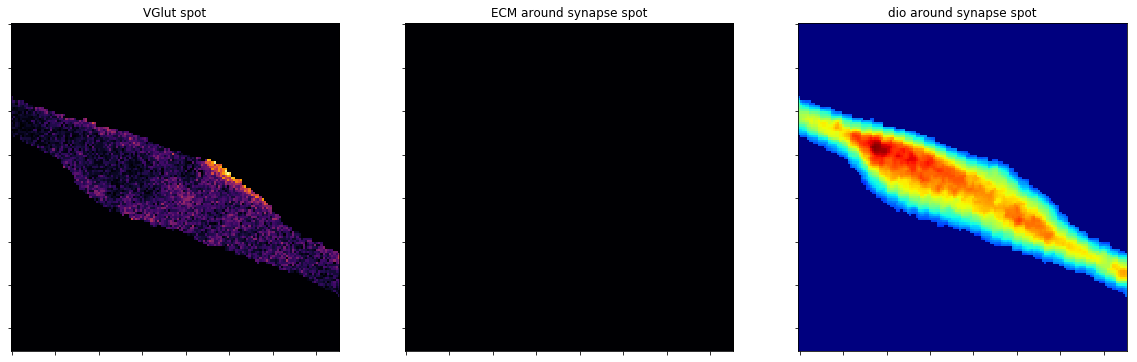

In [7]:
randomno=np.random.randint(1,len(df))
fig=plt.figure(figsize=(20,20))
fig.add_subplot(131)
plt.imshow(df["vglut spot aligned"][randomno],cmap='inferno')
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.gca().set(aspect='equal',adjustable='box')
plt.grid(False)
plt.title('VGlut spot')
fig.add_subplot(132)
plt.imshow(df["sted spot aligned"][randomno],cmap='inferno')
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.gca().set(aspect='equal',adjustable='box')
plt.grid(False)
plt.title('ECM around synapse spot')
fig.add_subplot(133)
plt.imshow(df["dio spot aligned"][randomno],cmap='jet')
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.gca().set(aspect='equal',adjustable='box')
plt.grid(False)
plt.title('dio around synapse spot')

## Add values, filtered by DiO channel

In [77]:
df["mean ecm intensity sted, bg subtracted"]=np.nan
df["mean vglut intensity sted, bg subtracted"]=np.nan

df["sted spot aligned under dio"]=df["sted spot aligned"]
df["ecm intensity sted, bg subtracted under dio"]=df["ecm intensity sted, bg subtracted"]
df["vglut spot aligned under dio"]=df["vglut spot aligned"]
df["vglut intensity sted, bg subtracted under dio"]=df["vglut intensity sted, bg subtracted"]

df["mean ecm intensity sted under dio"]=np.nan
df["mean vglut intensity sted under dio"]=np.nan
df["mean ecm intensity sted, bg subtracted under dio"]=np.nan
df["mean vglut intensity sted, bg subtracted under dio"]=np.nan

for i in range(0,len(df)):
    df["mean ecm intensity sted, bg subtracted"][i]=df["ecm intensity sted, bg subtracted"][i].mean()
    df["mean vglut intensity sted, bg subtracted"][i]=df["vglut intensity sted, bg subtracted"][i].mean()
    
    diomask=df["dio spot aligned"][i]>0
    image=df["sted spot aligned under dio"][i]
    image[~diomask]=0
    df["sted spot aligned under dio"][i]=image    
    image=df["ecm intensity sted, bg subtracted"][i]
    image[~diomask]=0
    df["ecm intensity sted, bg subtracted under dio"][i]=image    
    image=df["vglut spot aligned under dio"][i]
    image[~diomask]=0
    df["vglut spot aligned under dio"][i]=image    
    image=df["vglut intensity sted, bg subtracted"][i]
    image[~diomask]=0
    df["vglut intensity sted, bg subtracted under dio"][i]=image
    
    df["mean ecm intensity sted under dio"][i]=df["sted spot aligned under dio"][i].mean()
    df["mean vglut intensity sted under dio"][i]=df["vglut spot aligned under dio"][i].mean()
    df["mean ecm intensity sted, bg subtracted under dio"][i]=df["ecm intensity sted, bg subtracted"][i].mean()
    df["mean vglut intensity sted, bg subtracted under dio"][i]=df["vglut intensity sted, bg subtracted under dio"][i].mean()
df2=deepcopy(df)
df2=df2.reset_index()

/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/taldankovich/anaconda3/lib/pyt

## Add mean intensity normalized to unblocked control of that experiment

In [78]:
expnam=[]
unblockedtnr=[]
unblockedvglut=[]
for exp in df2["expname"].unique():
    dfexp=df2[df2["expname"]==exp]
    ub_tnr=dfexp[dfexp["Condition"]=="Unblocked Control"]["mean ecm intensity sted, bg subtracted"].mean()
    ub_vglut=dfexp[dfexp["Condition"]=="Unblocked Control"]["mean vglut intensity sted, bg subtracted"].mean()
    print(exp+' - ub tnr: '+str(ub_tnr)+' - ub vglut: '+str(ub_vglut))
    expnam.append(exp)
    unblockedtnr.append(ub_tnr)
    unblockedvglut.append(ub_vglut)
df2["ecm mean int norm2unblocked"]=np.nan
df2["vglut mean int norm2unblocked"]=np.nan
df2["ecm int norm2unblocked"]=df2["ecm intensity sted, bg subtracted"]
df2["vglut int norm2unblocked"]=df2["vglut intensity sted, bg subtracted"]
for i in range(0,len(df2)):
    if df2["expname"][i]==expnam[0]:
        df2["ecm mean int norm2unblocked"][i]=df2["mean ecm intensity sted, bg subtracted"][i]/unblockedtnr[0]
        df2["vglut mean int norm2unblocked"][i]=df2["mean vglut intensity sted, bg subtracted"][i]/unblockedvglut[0]
        df2["ecm int norm2unblocked"][i]=np.divide(df2["ecm intensity sted, bg subtracted"][i],unblockedtnr[0])
        df2["vglut int norm2unblocked"][i]=np.divide(df2["vglut intensity sted, bg subtracted"][i],unblockedvglut[0])
    if df2["expname"][i]==expnam[1]:
        df2["ecm mean int norm2unblocked"][i]=df2["mean ecm intensity sted, bg subtracted"][i]/unblockedtnr[1]
        df2["vglut mean int norm2unblocked"][i]=df2["mean vglut intensity sted, bg subtracted"][i]/unblockedvglut[1]
        df2["ecm int norm2unblocked"][i]=np.divide(df2["ecm intensity sted, bg subtracted"][i],unblockedtnr[1])
        df2["vglut int norm2unblocked"][i]=np.divide(df2["vglut intensity sted, bg subtracted"][i],unblockedvglut[1])
    if df2["expname"][i]==expnam[2]:
        df2["ecm mean int norm2unblocked"][i]=df2["mean ecm intensity sted, bg subtracted"][i]/unblockedtnr[2]
        df2["vglut mean int norm2unblocked"][i]=df2["mean vglut intensity sted, bg subtracted"][i]/unblockedvglut[2]
        df2["ecm int norm2unblocked"][i]=np.divide(df2["ecm intensity sted, bg subtracted"][i],unblockedtnr[2])
        df2["vglut int norm2unblocked"][i]=np.divide(df2["vglut intensity sted, bg subtracted"][i],unblockedvglut[2])
    if df2["expname"][i]==expnam[3]:
        df2["ecm mean int norm2unblocked"][i]=df2["mean ecm intensity sted, bg subtracted"][i]/unblockedtnr[3]
        df2["vglut mean int norm2unblocked"][i]=df2["mean vglut intensity sted, bg subtracted"][i]/unblockedvglut[3]
        df2["ecm int norm2unblocked"][i]=np.divide(df2["ecm intensity sted, bg subtracted"][i],unblockedtnr[3])
        df2["vglut int norm2unblocked"][i]=np.divide(df2["vglut intensity sted, bg subtracted"][i],unblockedvglut[3])


20190216_TNR580_DiO_VGlut647 - ub tnr: 0.03504584577149519 - ub vglut: 2.2045963565937012
20190225_TNR647_VGlut580_DiO - ub tnr: 0.2558247475901424 - ub vglut: 1.6615455276961448
20190302_TNR647_Vglut580_DiO - ub tnr: 0.5304934434871987 - ub vglut: 0.7456106262799833
20190307_TNR647_VGlut580_DiO_analyse - ub tnr: 0.4935249891892497 - ub vglut: 0.6583389625317414


/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning

In [79]:
expnam=[]
unblockedtnr=[]
unblockedvglut=[]
for exp in df2["expname"].unique():
    dfexp=df2[df2["expname"]==exp]
    ub_tnr=dfexp[dfexp["Condition"]=="Unblocked Control"]["mean ecm intensity sted, bg subtracted"].mean()
    ub_vglut=dfexp[dfexp["Condition"]=="Unblocked Control"]["mean vglut intensity sted, bg subtracted"].mean()
    print(exp+' - ub tnr: '+str(ub_tnr)+' - ub vglut: '+str(ub_vglut))
    expnam.append(exp)
    unblockedtnr.append(ub_tnr)
    unblockedvglut.append(ub_vglut)
df2["ecm mean int norm2unblocked under dio"]=np.nan
df2["vglut mean int norm2unblocked under dio"]=np.nan
df2["ecm int norm2unblocked under dio"]=df2["ecm intensity sted, bg subtracted under dio"]
df2["vglut int norm2unblocked under dio"]=df2["vglut intensity sted, bg subtracted under dio"]
for i in range(0,len(df2)):
    if df2["expname"][i]==expnam[0]:
        df2["ecm mean int norm2unblocked under dio"][i]=df2["mean ecm intensity sted, bg subtracted under dio"][i]/unblockedtnr[0]
        df2["vglut mean int norm2unblocked under dio"][i]=df2["mean vglut intensity sted, bg subtracted under dio"][i]/unblockedvglut[0]
        df2["ecm int norm2unblocked under dio"][i]=np.divide(df2["ecm intensity sted, bg subtracted under dio"][i],unblockedtnr[0])
        df2["vglut int norm2unblocked under dio"][i]=np.divide(df2["vglut intensity sted, bg subtracted under dio"][i],unblockedvglut[0])
    if df2["expname"][i]==expnam[1]:
        df2["ecm mean int norm2unblocked under dio"][i]=df2["mean ecm intensity sted, bg subtracted under dio"][i]/unblockedtnr[1]
        df2["vglut mean int norm2unblocked under dio"][i]=df2["mean vglut intensity sted, bg subtracted under dio"][i]/unblockedvglut[1]
        df2["ecm int norm2unblocked under dio"][i]=np.divide(df2["ecm intensity sted, bg subtracted under dio"][i],unblockedtnr[1])
        df2["vglut int norm2unblocked under dio"][i]=np.divide(df2["vglut intensity sted, bg subtracted under dio"][i],unblockedvglut[1])
    if df2["expname"][i]==expnam[2]:
        df2["ecm mean int norm2unblocked under dio"][i]=df2["mean ecm intensity sted, bg subtracted under dio"][i]/unblockedtnr[2]
        df2["vglut mean int norm2unblocked under dio"][i]=df2["mean vglut intensity sted, bg subtracted under dio"][i]/unblockedvglut[2]
        df2["ecm int norm2unblocked under dio"][i]=np.divide(df2["ecm intensity sted, bg subtracted under dio"][i],unblockedtnr[2])
        df2["vglut int norm2unblocked under dio"][i]=np.divide(df2["vglut intensity sted, bg subtracted under dio"][i],unblockedvglut[2])
    if df2["expname"][i]==expnam[3]:
        df2["ecm mean int norm2unblocked under dio"][i]=df2["mean ecm intensity sted, bg subtracted under dio"][i]/unblockedtnr[3]
        df2["vglut mean int norm2unblocked under dio"][i]=df2["mean vglut intensity sted, bg subtracted under dio"][i]/unblockedvglut[3]
        df2["ecm int norm2unblocked under dio"][i]=np.divide(df2["ecm intensity sted, bg subtracted under dio"][i],unblockedtnr[3])
        df2["vglut int norm2unblocked under dio"][i]=np.divide(df2["vglut intensity sted, bg subtracted under dio"][i],unblockedvglut[3])



20190216_TNR580_DiO_VGlut647 - ub tnr: 0.03504584577149519 - ub vglut: 2.2045963565937012
20190225_TNR647_VGlut580_DiO - ub tnr: 0.2558247475901424 - ub vglut: 1.6615455276961448
20190302_TNR647_Vglut580_DiO - ub tnr: 0.5304934434871987 - ub vglut: 0.7456106262799833
20190307_TNR647_VGlut580_DiO_analyse - ub tnr: 0.4935249891892497 - ub vglut: 0.6583389625317414


/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning

## Make separate dataframes for exp conditions and morphologies

Backup

In [81]:
df3=deepcopy(df2)

In [82]:
df2=df2[df2["expname"]!="20190216_TNR580_DiO_VGlut647"]
df2_newepitopes_dmso=df2[(df2["Condition"]!="Unblocked Control")&
                         (df2["Drug"]=="DMSO")]
df2_newepitopes_bic=df2[(df2["Condition"]!="Unblocked Control")&
                         (df2["Drug"]=="Bic")]
df2_newepitopes_all=df2[(df2["Condition"]!="Unblocked Control")]

df2_unblocked=df2[df2["Condition"]=="Unblocked Control"]

df2mushrooms_unblocked=df2_unblocked[df2_unblocked["classification"]==1.0]
df2flats_unblocked=df2_unblocked[df2_unblocked["classification"]==2.0]
df2boutons_unblocked=df2_unblocked[df2_unblocked["classification"]==3.0]

df2mushrooms_newepitopes_all=df2_newepitopes_all[df2_newepitopes_all["classification"]==1.0]
df2flats_newepitopes_all=df2_newepitopes_all[df2_newepitopes_all["classification"]==2.0]
df2boutons_newepitopes_all=df2_newepitopes_all[df2_newepitopes_all["classification"]==3.0]

df2mushrooms_newepitopes_bic=df2_newepitopes_bic[df2_newepitopes_bic["classification"]==1.0]
df2flats_newepitopes_bic=df2_newepitopes_bic[df2_newepitopes_bic["classification"]==2.0]
df2boutons_newepitopes_bic=df2_newepitopes_bic[df2_newepitopes_bic["classification"]==3.0]

df2mushrooms_newepitopes_dmso=df2_newepitopes_dmso[df2_newepitopes_dmso["classification"]==1.0]
df2flats_newepitopes_dmso=df2_newepitopes_dmso[df2_newepitopes_dmso["classification"]==2.0]
df2boutons_newepitopes_dmso=df2_newepitopes_dmso[df2_newepitopes_dmso["classification"]==3.0]

## No. synapses

In [83]:
len(df2)

1439

## Make average images, all conditions, all morphologies

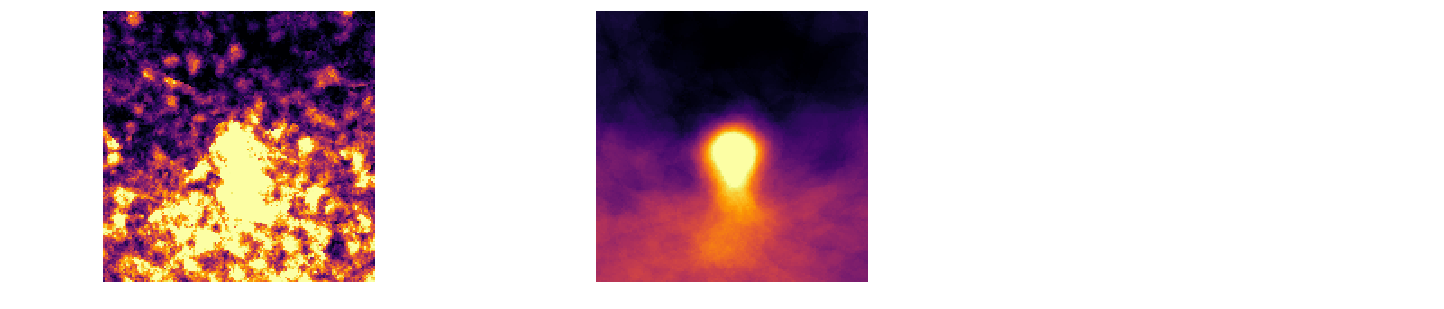

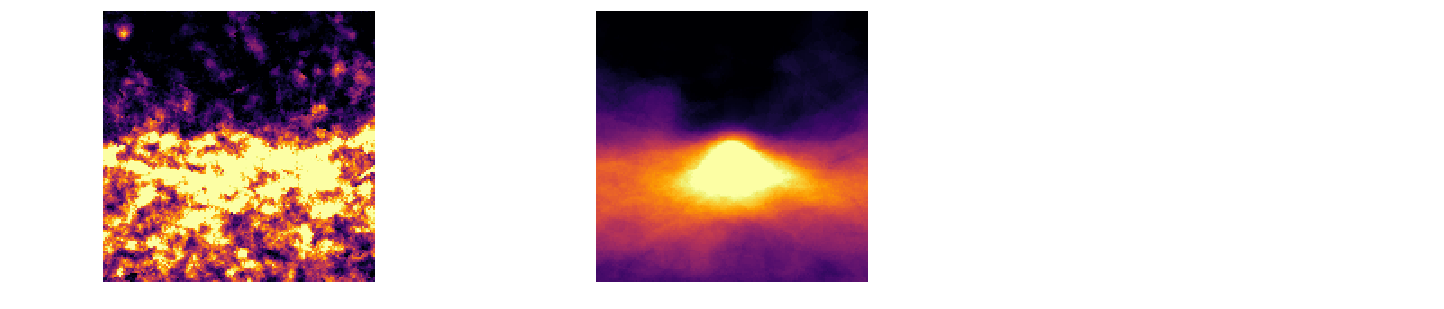

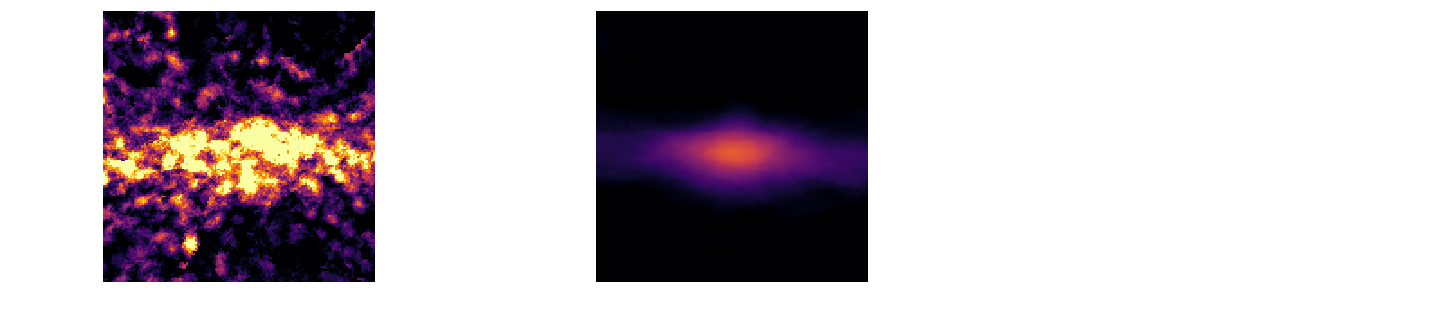

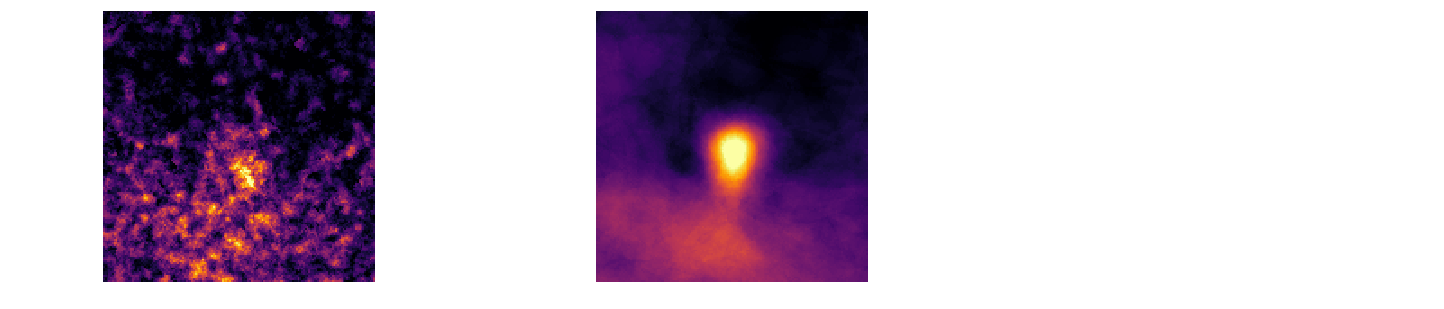

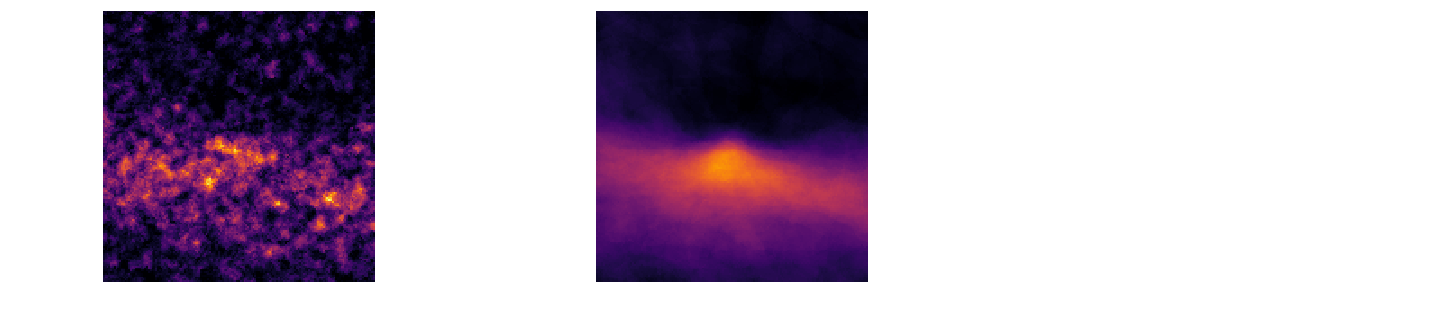

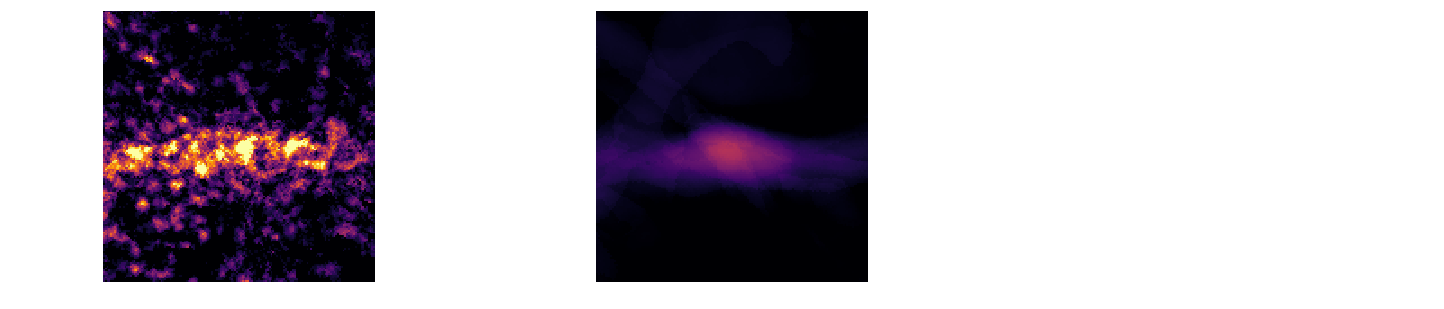

In [247]:
var="ecm intensity sted, bg subtracted"
diri="/Volumes/Macintosh HD/Users/taldankovich/Downloads/figures/"

df22plot=df2mushrooms_unblocked
fig=plt.figure(figsize=(25,5))
plt.axis('off')
#plt.title(str(i))
fig.add_subplot(131)
plt.imshow(df22plot[var].mean()
           ,cmap='inferno',
           vmin=df2[var].mean().min(),
           vmax=np.max(df2[var].mean()))
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                   font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
#plt.gca().add_artist(scalebar)
plt.axis('off')
data=df22plot[var].mean()
im = Image.fromarray(data)
im.save(diri+'figure2_mushrooms_unblocked_sted.tiff')

fig.add_subplot(132)
plt.imshow(df22plot["dio spot aligned"].mean()
           ,cmap='inferno',
           vmin=np.min(df2["dio spot aligned"].mean()),
           vmax=np.max(df2["dio spot aligned"].mean()))
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                   font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
#plt.gca().add_artist(scalebar)
plt.axis('off')
data=df22plot["dio spot aligned"].mean()
im = Image.fromarray(data)
im.save(diri+'figure2_mushrooms_unblocked_dio.tiff')


######################################################################################################################

df22plot=df2flats_unblocked
fig=plt.figure(figsize=(25,5))
plt.axis('off')
#plt.title(str(i))
fig.add_subplot(131)
plt.imshow(df22plot[var].mean()
           ,cmap='inferno',
           vmin=df2[var].mean().min(),
           vmax=np.max(df2[var].mean()))
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                   font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
#plt.gca().add_artist(scalebar)
plt.axis('off')
data=df22plot[var].mean()
im = Image.fromarray(data)
im.save(diri+'figure2_flats_unblocked_sted.tiff')

fig.add_subplot(132)
plt.imshow(df22plot["dio spot aligned"].mean()
           ,cmap='inferno',
           vmin=np.min(df2["dio spot aligned"].mean()),
           vmax=np.max(df2["dio spot aligned"].mean()))
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                   font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
#plt.gca().add_artist(scalebar)
plt.axis('off')
data=df22plot["dio spot aligned"].mean()
im = Image.fromarray(data)
im.save(diri+'figure2_flats_unblocked_dio.tiff')

######################################################################################################################

df22plot=df2boutons_unblocked
fig=plt.figure(figsize=(25,5))
plt.axis('off')
#plt.title(str(i))
fig.add_subplot(131)
plt.imshow(df22plot[var].mean()
           ,cmap='inferno',
           vmin=df2[var].mean().min(),
           vmax=np.max(df2[var].mean()))
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                   font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
#plt.gca().add_artist(scalebar)
plt.axis('off')
data=df22plot[var].mean()
im = Image.fromarray(data)
im.save(diri+'figure2_boutons_unblocked_sted.tiff')

fig.add_subplot(132)
plt.imshow(df22plot["dio spot aligned"].mean()
           ,cmap='inferno',
           vmin=np.min(df2["dio spot aligned"].mean()),
           vmax=np.max(df2["dio spot aligned"].mean()))
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                   font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
#plt.gca().add_artist(scalebar)
plt.axis('off')
data=df22plot["dio spot aligned"].mean()
im = Image.fromarray(data)
im.save(diri+'figure2_boutons_unblocked_dio.tiff')

######################################################################################################################

df22plot=df2mushrooms_newepitopes_dmso
fig=plt.figure(figsize=(25,5))
plt.axis('off')
#plt.title(str(i))
fig.add_subplot(131)
plt.imshow(df22plot[var].mean()
           ,cmap='inferno',
           vmin=df2[var].mean().min(),
           vmax=np.max(df2[var].mean()))
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                   font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
#plt.gca().add_artist(scalebar)
plt.axis('off')
data=df22plot[var].mean()
im = Image.fromarray(data)
im.save(diri+'figure2_mushrooms_newepitopes_sted.tiff')

fig.add_subplot(132)
plt.imshow(df22plot["dio spot aligned"].mean()
           ,cmap='inferno',
           vmin=np.min(df2["dio spot aligned"].mean()),
           vmax=np.max(df2["dio spot aligned"].mean()))
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                   font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
#plt.gca().add_artist(scalebar)
plt.axis('off')
data=df22plot["dio spot aligned"].mean()
im = Image.fromarray(data)
im.save(diri+'figure2_mushrooms_newepitopes_dio.tiff')
######################################################################################################################

df22plot=df2flats_newepitopes_dmso
fig=plt.figure(figsize=(25,5))
plt.axis('off')
#plt.title(str(i))
fig.add_subplot(131)
plt.imshow(df22plot[var].mean()
           ,cmap='inferno',
           vmin=df2[var].mean().min(),
           vmax=np.max(df2[var].mean()))
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                   font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
#plt.gca().add_artist(scalebar)
plt.axis('off')
data=df22plot[var].mean()
im = Image.fromarray(data)
im.save(diri+'figure2_flats_newepitopes_sted.tiff')



fig.add_subplot(132)
plt.imshow(df22plot["dio spot aligned"].mean()
           ,cmap='inferno',
           vmin=np.min(df2["dio spot aligned"].mean()),
           vmax=np.max(df2["dio spot aligned"].mean()))
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                   font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
#plt.gca().add_artist(scalebar)
plt.axis('off')
data=df22plot["dio spot aligned"].mean()
im = Image.fromarray(data)
im.save(diri+'figure2_flats_newepitopes_dio.tiff')

######################################################################################################################
df22plot=df2boutons_newepitopes_dmso
fig=plt.figure(figsize=(25,5))
plt.axis('off')
#plt.title(str(i))
fig.add_subplot(131)
plt.imshow(df22plot[var].mean()
           ,cmap='inferno',
           vmin=df2[var].mean().min(),
           vmax=np.max(df2[var].mean()))
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                   font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
#plt.gca().add_artist(scalebar)
plt.axis('off')
data=df22plot[var].mean()
im = Image.fromarray(data)
im.save(diri+'figure2_boutons_newepitopes_sted.tiff')



fig.add_subplot(132)
plt.imshow(df22plot["dio spot aligned"].mean()
           ,cmap='inferno',
           vmin=np.min(df2["dio spot aligned"].mean()),
           vmax=np.max(df2["dio spot aligned"].mean()))
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                   font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
#plt.gca().add_artist(scalebar)
plt.axis('off')
data=df22plot["dio spot aligned"].mean()
im = Image.fromarray(data)
im.save(diri+'figure2_boutons_newepitopes.tiff')

## Plot new epitopes + bic average images

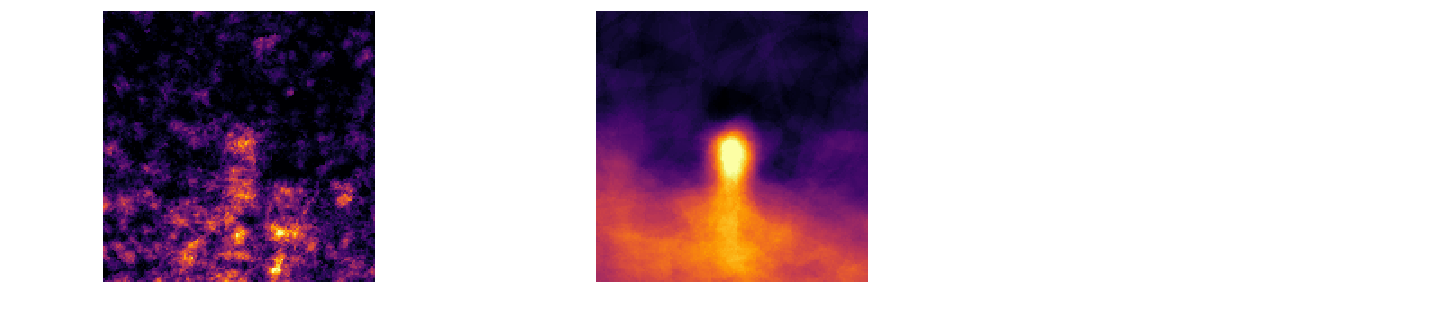

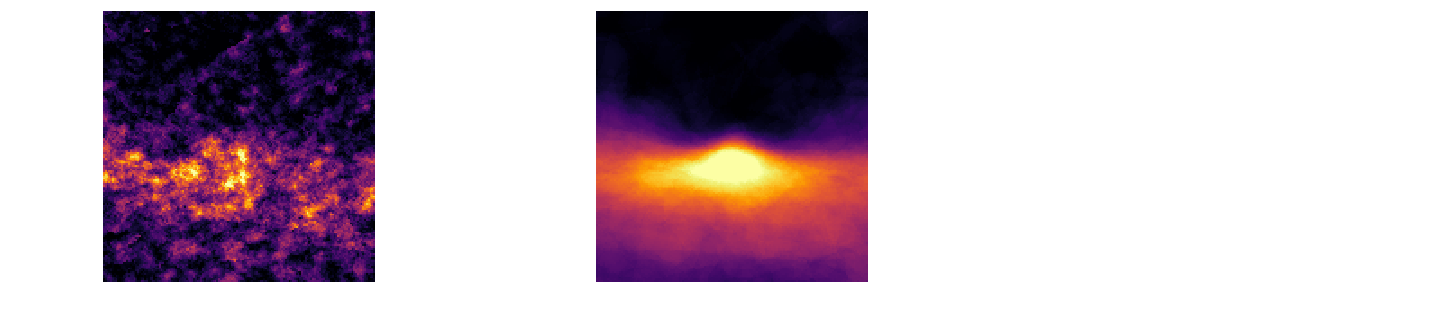

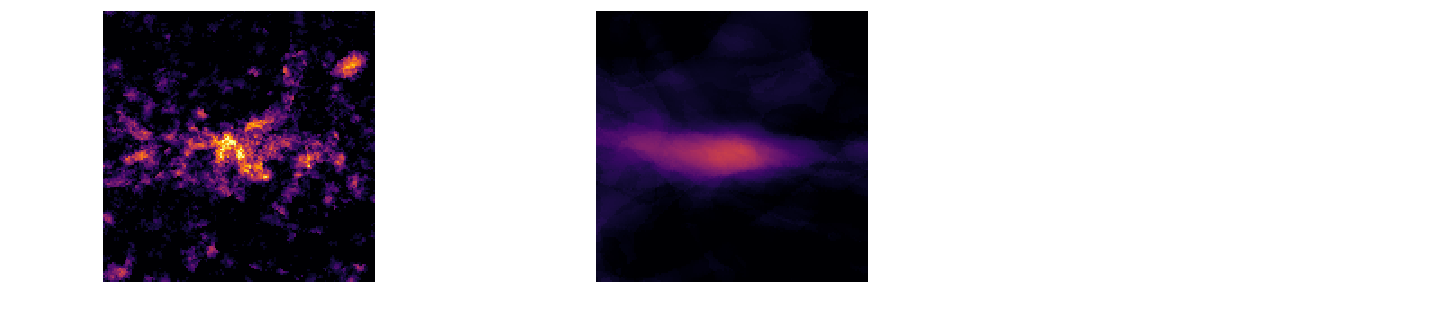

In [250]:
diri="/Volumes/Macintosh HD/Users/taldankovich/Downloads/figures/"


df22plot=df2mushrooms_newepitopes_bic
fig=plt.figure(figsize=(25,5))
plt.axis('off')
#plt.title(str(i))
fig.add_subplot(131)
plt.imshow(df22plot["ecm intensity sted, bg subtracted"].mean()
           ,cmap='inferno',
           vmin=df2["ecm intensity sted, bg subtracted"].mean().min(),
           vmax=np.max(df2["ecm intensity sted, bg subtracted"].mean()))
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                   font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
#plt.gca().add_artist(scalebar)
plt.axis('off')
data=df22plot["ecm intensity sted, bg subtracted"].mean()
im = Image.fromarray(data)
im.save(diri+'figure2_mushrooms_newepitopesbic_sted.tiff')

fig.add_subplot(132)
plt.imshow(df22plot["dio spot aligned"].mean()
           ,cmap='inferno',
           vmin=np.min(df2["dio spot aligned"].mean()),
           vmax=np.max(df2["dio spot aligned"].mean()))
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                   font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
#plt.gca().add_artist(scalebar)
plt.axis('off')
data=df22plot["dio spot aligned"].mean()
im = Image.fromarray(data)
im.save(diri+'figure2_mushrooms_newepitopesbic_dio.tiff')
######################################################################################################################

df22plot=df2flats_newepitopes_bic
fig=plt.figure(figsize=(25,5))
plt.axis('off')
#plt.title(str(i))
fig.add_subplot(131)
plt.imshow(df22plot["ecm intensity sted, bg subtracted"].mean()
           ,cmap='inferno',
           vmin=df2["ecm intensity sted, bg subtracted"].mean().min(),
           vmax=np.max(df2["ecm intensity sted, bg subtracted"].mean()))
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                   font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
#plt.gca().add_artist(scalebar)
plt.axis('off')
data=df22plot["ecm intensity sted, bg subtracted"].mean()
im = Image.fromarray(data)
im.save(diri+'figure2_flats_newepitopesbic_sted.tiff')



fig.add_subplot(132)
plt.imshow(df22plot["dio spot aligned"].mean()
           ,cmap='inferno',
           vmin=np.min(df2["dio spot aligned"].mean()),
           vmax=np.max(df2["dio spot aligned"].mean()))
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                   font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
#plt.gca().add_artist(scalebar)
plt.axis('off')
data=df22plot["dio spot aligned"].mean()
im = Image.fromarray(data)
im.save(diri+'figure2_flats_newepitopesbic_dio.tiff')

######################################################################################################################
df22plot=df2boutons_newepitopes_bic
fig=plt.figure(figsize=(25,5))
plt.axis('off')
#plt.title(str(i))
fig.add_subplot(131)
plt.imshow(df22plot["ecm intensity sted, bg subtracted"].mean()
           ,cmap='inferno',
           vmin=df2["ecm intensity sted, bg subtracted"].mean().min(),
           vmax=np.max(df2["ecm intensity sted, bg subtracted"].mean()))
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                   font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
#plt.gca().add_artist(scalebar)
plt.axis('off')
data=df22plot["ecm intensity sted, bg subtracted"].mean()
im = Image.fromarray(data)
im.save(diri+'figure2_boutons_newepitopesbic_sted.tiff')



fig.add_subplot(132)
plt.imshow(df22plot["dio spot aligned"].mean()
           ,cmap='inferno',
           vmin=np.min(df2["dio spot aligned"].mean()),
           vmax=np.max(df2["dio spot aligned"].mean()))
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                   font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
#plt.gca().add_artist(scalebar)
plt.axis('off')
data=df22plot["dio spot aligned"].mean()
im = Image.fromarray(data)
im.save(diri+'figure2_boutons_newepitopesbic.tiff')

## Add more labels to df

In [86]:
dfbackup=deepcopy(df2)

In [87]:
df2["Epitopes old/new"]='None'
df2.loc[df2["Condition"]=="Unblocked Control","Epitopes old/new"]="All (unblocked)"
df2.loc[df2["Condition"]=="12hr + Bic","Epitopes old/new"]="New"
df2.loc[df2["Condition"]=="12hr + DMSO","Epitopes old/new"]="New"
df2["Drug"]='None'
df2.loc[df2["Condition"]=="12hr + Bic","Drug"]="Bic"
df2.loc[df2["Condition"]=="12hr + DMSO","Drug"]="DMSO"
df2["Cond_type"]='None'
df2.loc[(df2["Condition"]=="12hr + Bic")&(df2["Type"]=="Mushroom"),"Cond_type"]="New, bic, mushroom"
df2.loc[(df2["Condition"]=="12hr + DMSO")&(df2["Type"]=="Mushroom"),"Cond_type"]="New, dmso, mushroom"
df2.loc[(df2["Condition"]=="12hr + Bic")&(df2["Type"]=="Flat"),"Cond_type"]="New, bic, flat"
df2.loc[(df2["Condition"]=="12hr + DMSO")&(df2["Type"]=="Flat"),"Cond_type"]="New, dmso, flat"
df2.loc[(df2["Condition"]=="12hr + Bic")&(df2["Type"]=="Bouton"),"Cond_type"]="New, bic, bouton"
df2.loc[(df2["Condition"]=="12hr + DMSO")&(df2["Type"]=="Bouton"),"Cond_type"]="New, dmso, bouton"

df2.loc[(df2["Condition"]=="Unblocked Control")&(df2["Type"]=="Mushroom"),"Cond_type"]="All, mushroom"
df2.loc[(df2["Condition"]=="Unblocked Control")&(df2["Type"]=="Flat"),"Cond_type"]="All, flat"
df2.loc[(df2["Condition"]=="Unblocked Control")&(df2["Type"]=="Bouton"),"Cond_type"]="All, bouton"

## Remove outliers

In [251]:
df4=deepcopy(df2)#[df2["Type"]!="Bouton"])
vari="mean vglut intensity sted"
quant=.99

for i in range(0,len(df4["Cond_type"].unique())):
    cond=df4["Cond_type"].unique()[i]
    print(cond)
    if i==0:
        dfnewi=df4[df4["Cond_type"]==cond]
        dfnewi=dfnewi[dfnewi[vari]<
            dfnewi[vari].quantile(quant)]
    else:
        dfnew=df4[df4["Cond_type"]==cond]
        dfnew=dfnew[dfnew[vari]<
                dfnew[vari].quantile(quant)]
    if i>0:
        dfnewi=pd.concat([dfnewi,dfnew])

All, mushroom
All, flat
All, bouton
New, bic, flat
New, bic, bouton
New, bic, mushroom
New, dmso, flat
New, dmso, mushroom
New, dmso, bouton


## ttests

In [252]:
var="ecm mean int norm2unblocked"
df2plot=dfnewi.reset_index(drop=True)

unblockedmush=df2plot[df2plot["Cond_type"]=="All, mushroom"][var].dropna().values
unblockedflat=df2plot[df2plot["Cond_type"]=="All, flat"][var].dropna().values

newmushdmso=df2plot[df2plot["Cond_type"]=="New, dmso, mushroom"][var].dropna().values
newflatdmso=df2plot[df2plot["Cond_type"]=="New, dmso, flat"][var].dropna().values

newmushbic=df2plot[df2plot["Cond_type"]=="New, bic, mushroom"][var].dropna().values
newflatbic=df2plot[df2plot["Cond_type"]=="New, bic, flat"][var].dropna().values


[stat,pval_1]=stats.ttest_ind(unblockedmush, unblockedflat)
[stat,pval_2]=stats.ttest_ind(newmushdmso, newflatdmso)
[stat,pval_3]=stats.ttest_ind(newmushbic, newflatbic)

print(pval_1)
print(pval_2)
print(pval_3)

0.30333118908120615
0.6545659258289547
0.03249245217407664


## Plots

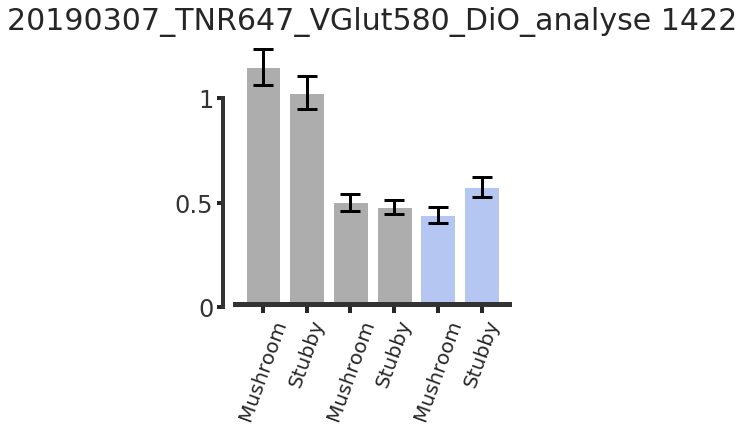

In [253]:
sns.set(font_scale=2.5)
sns.set_style("ticks")
sns.set_palette("Set2")
from matplotlib import ticker

var="ecm mean int norm2unblocked"
fig=plt.figure(figsize=(5,5))
palette={"All, mushroom": "#adadad",
         "All, flat": "#adadad",
         "New, dmso, mushroom":"#adadad",
         "New, dmso, flat":"#adadad",
        "New, bic, mushroom":"#abc2fc",
         "New, bic, flat":"#abc2fc"}
order=["All, mushroom","All, flat","New, dmso, mushroom","New, dmso, flat",
      "New, bic, mushroom","New, bic, flat"]

g=sns.barplot(data=df2plot,y=var,x="Cond_type"
            ,order=order,palette=palette,ci=None)
plt.title(exp+" "+str(len(df2plot)))
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        # we change the bar width
        patch.set_width(new_value)
        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
        
change_width(g, .8)

plt.errorbar(x=np.arange(0,len(order)),
             y=[df2plot[df2plot["Cond_type"]==condtype][var].mean() for condtype in order],
             yerr=[df2plot[df2plot["Cond_type"]==condtype][var].sem() for condtype in order],
             xerr=None,ecolor='black',fmt='none',capsize=10,linewidth=3,
             capthick=3,zorder=10,
            alpha=1)

#plt.ylim([0,0.5])
plt.axhline(0, color='#333333',alpha=1,linewidth=10)


scale_y=1/1
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
g.yaxis.set_major_formatter(ticks_y)
g.xaxis.set_tick_params(width=4)
g.yaxis.set_tick_params(width=4)
plt.rcParams['font.sans-serif'] = 'Helvetica'
for axis in ['top','bottom','left','right']:
  g.spines[axis].set_linewidth(4)
  g.spines[axis].set_color('#333333')
  g.spines[axis].set_alpha(1)
offsets={"left":10,"bottom":0}
trims={"left":True,"bottom":False,"right":False}
sns.despine(ax=g,right=True,top=True,bottom=True,trim=trims,offset=offsets)
g.set_ylabel('')
g.set_xlabel('',color='#333333',alpha=.7)
plt.xticks(g.get_xticks(),['Mushroom','Stubby','Mushroom','Stubby','Mushroom','Stubby'],
           rotation=70,size=20)
plt.yticks(g.get_yticks(),size=24,color='#333333')
g.grid(False)

diri="/Volumes/Macintosh HD/Users/taldankovich/Downloads/figures/"
#fig.savefig(diri+'2c_postsynpasesdio_mushstubby.svg', bbox_inches='tight', format='svg')

In [93]:
for cond in order:
    print(cond)
    print(len(df2plot[df2plot["Cond_type"]==cond]))

All, mushroom
171
All, flat
156
New, dmso, mushroom
175
New, dmso, flat
240
New, bic, mushroom
170
New, bic, flat
192


## Plot unblocked

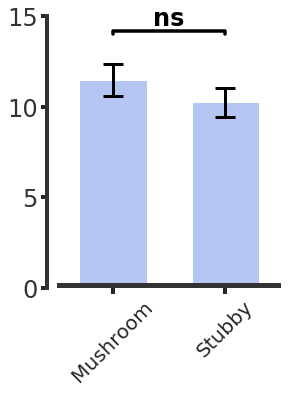

In [254]:
sns.set(font_scale=2.5)
sns.set_style("ticks")
sns.set_palette("Set2")
from matplotlib import ticker
plt.rcParams['font.sans-serif'] = 'Helvetica'

fig=plt.figure(figsize=(4,5))
palette={"All, mushroom": "#adadad",
         "All, flat": "#adadad",
         "New, dmso, mushroom":"#adadad",
         "New, dmso, flat":"#adadad",
        "New, bic, mushroom":"#abc2fc",
         "New, bic, flat":"#abc2fc"}

order=["All, mushroom","All, flat"]

g=sns.barplot(data=df2plot,y=var,x="Cond_type"
            ,order=order,color="#abc2fc",ci=None)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        # we change the bar width
        patch.set_width(new_value)
        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
        
change_width(g, .6)

plt.errorbar(x=np.arange(0,len(order)),
             y=[df2plot[df2plot["Cond_type"]==condtype][var].mean() for condtype in order],
             yerr=[df2plot[df2plot["Cond_type"]==condtype][var].sem() for condtype in order],
             xerr=None,ecolor='black',fmt='none',capsize=10,linewidth=3,
             capthick=3,zorder=10,
            alpha=1)

plt.ylim([0,1.5])
plt.axhline(0, color='#333333',alpha=1,linewidth=10)

scale_y=1/10
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
g.yaxis.set_major_formatter(ticks_y)
plt.yticks([0,.5,1,1.5],color='#333333')
g.xaxis.set_tick_params(width=4)
g.yaxis.set_tick_params(width=4)
plt.rcParams['font.sans-serif'] = 'Helvetica'
for axis in ['top','bottom','left','right']:
  g.spines[axis].set_linewidth(4)
  g.spines[axis].set_color('#333333')
  g.spines[axis].set_alpha(1)
offsets={"left":10,"bottom":0}
trims={"left":True,"bottom":False,"right":False}
sns.despine(ax=g,right=True,top=True,bottom=True,trim=trims,offset=offsets)
g.set_ylabel('')
g.set_xlabel('',color='#333333',alpha=.7)
plt.xticks(g.get_xticks(),['Mushroom','Stubby'],
           rotation=45,size=20)
plt.yticks(g.get_yticks(),size=24,color='#333333')
g.grid(False)


x1, x2 = 0,1
y= 1.4
h=0.02
col='black'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)
plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col,size=24, weight='bold')

diri="/Volumes/Macintosh HD/Users/taldankovich/Downloads/figures/"
fig.savefig(diri+'supp3_postsynpasesdio_mushstubby_alleps.svg', bbox_inches='tight', format='svg')

## Plot new epitopes

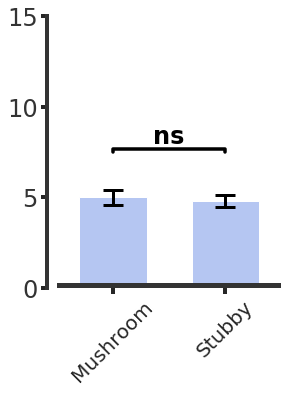

In [255]:
sns.set(font_scale=2.5)
sns.set_style("ticks")
sns.set_palette("Set2")
from matplotlib import ticker
plt.rcParams['font.sans-serif'] = 'Helvetica'
#var="ecm mean int norm2med"
fig=plt.figure(figsize=(4,5))
palette={"All, mushroom": "#adadad",
         "All, flat": "#adadad",
         "New, dmso, mushroom":"#adadad",
         "New, dmso, flat":"#adadad",
        "New, bic, mushroom":"#abc2fc",
         "New, bic, flat":"#abc2fc"}

order=["New, dmso, mushroom","New, dmso, flat"]

g=sns.barplot(data=df2plot,y=var,x="Cond_type"
            ,order=order,color="#abc2fc",ci=None)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        
        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
        
change_width(g, .6)

plt.errorbar(x=np.arange(0,len(order)),
             y=[df2plot[df2plot["Cond_type"]==condtype][var].mean() for condtype in order],
             yerr=[df2plot[df2plot["Cond_type"]==condtype][var].sem() for condtype in order],
             xerr=None,ecolor='black',fmt='none',capsize=10,linewidth=3,
             capthick=3,zorder=10,
            alpha=1)

plt.ylim([0,1.5])
plt.axhline(0, color='#333333',alpha=1,linewidth=10)
scale_y=1/10
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
g.yaxis.set_major_formatter(ticks_y)
plt.yticks([0,.5,1,1.5],color='#333333')
g.xaxis.set_tick_params(width=4)
g.yaxis.set_tick_params(width=4)
plt.rcParams['font.sans-serif'] = 'Helvetica'
for axis in ['top','bottom','left','right']:
  g.spines[axis].set_linewidth(4)
  g.spines[axis].set_color('#333333')
  g.spines[axis].set_alpha(1)
offsets={"left":10,"bottom":0}
trims={"left":True,"bottom":False,"right":False}
sns.despine(ax=g,right=True,top=True,bottom=True,trim=trims,offset=offsets)
g.set_ylabel('')
g.set_xlabel('',color='#333333',alpha=.7)
plt.xticks(g.get_xticks(),['Mushroom','Stubby'],
           rotation=45,size=20)
plt.yticks(g.get_yticks(),size=24,color='#333333')
g.grid(False)


x1, x2 = 0,1
y= 0.75
h=0.02
col='black'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)
plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col,size=24, weight='bold')


diri="/Volumes/Macintosh HD/Users/taldankovich/Downloads/figures/"
fig.savefig(diri+'supp3_postsynpasesdio_mushstubby_neweps.svg', bbox_inches='tight', format='svg')

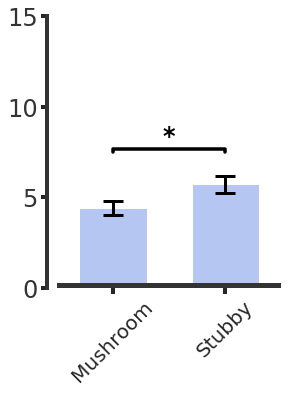

In [256]:
sns.set(font_scale=2.5)
sns.set_style("ticks")
sns.set_palette("Set2")
from matplotlib import ticker
plt.rcParams['font.sans-serif'] = 'Helvetica'
fig=plt.figure(figsize=(4,5))
palette={"All, mushroom": "#adadad",
         "All, flat": "#adadad",
         "New, dmso, mushroom":"#adadad",
         "New, dmso, flat":"#adadad",
        "New, bic, mushroom":"#abc2fc",
         "New, bic, flat":"#abc2fc"}

order=["New, bic, mushroom","New, bic, flat"]

g=sns.barplot(data=df2plot,y=var,x="Cond_type"
            ,order=order,color="#abc2fc",ci=None)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        
        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
        
change_width(g, .6)

plt.errorbar(x=np.arange(0,len(order)),
             y=[df2plot[df2plot["Cond_type"]==condtype][var].mean() for condtype in order],
             yerr=[df2plot[df2plot["Cond_type"]==condtype][var].sem() for condtype in order],
             xerr=None,ecolor='black',fmt='none',capsize=10,linewidth=3,
             capthick=3,zorder=10,
            alpha=1)

plt.ylim([0,1.5])
plt.axhline(0, color='#333333',alpha=1,linewidth=10)
scale_y=1/10
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
g.yaxis.set_major_formatter(ticks_y)
plt.yticks([0,.5,1,1.5],color='#333333')
g.xaxis.set_tick_params(width=4)
g.yaxis.set_tick_params(width=4)
plt.rcParams['font.sans-serif'] = 'Helvetica'
for axis in ['top','bottom','left','right']:
  g.spines[axis].set_linewidth(4)
  g.spines[axis].set_color('#333333')
  g.spines[axis].set_alpha(1)
offsets={"left":10,"bottom":0}
trims={"left":True,"bottom":False,"right":False}
sns.despine(ax=g,right=True,top=True,bottom=True,trim=trims,offset=offsets)
g.set_ylabel('')
g.set_xlabel('',color='#333333',alpha=.7)
plt.xticks(g.get_xticks(),['Mushroom','Stubby'],
           rotation=45,size=20)
plt.yticks(g.get_yticks(),size=24,color='#333333')
g.grid(False)


x1, x2 = 0,1
y= 0.75
h=0.02
col='black'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)
plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col,size=24, weight='bold')


diri="/Volumes/Macintosh HD/Users/taldankovich/Downloads/figures/"
fig.savefig(diri+'supp3_postsynpasesdio_mushstubby_newepsbic.svg', bbox_inches='tight', format='svg')

## Check correlation to size

In [259]:
df_withsize=deepcopy(df2)
df_withsize=df_withsize.reset_index(drop=True)
df_withsize["size"]=np.nan
for i in range(0,len(df_withsize)):
    diomask=df_withsize["dio spot aligned"][i]>0
    size=np.nansum(diomask)
    df_withsize["size"][i]=size

/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [260]:
##sort df according to synapse intensity
df3=deepcopy(df_withsize)
df3=df3.sort_values("size",ascending=True)
df3=df3.reset_index(drop=True)
#split into 5 separate dfs, add column with number
a, b, c,d,e = np.split(df3, [int(.2*len(df3)),int(.4*len(df3)),int(.6*len(df3)),int(.8*len(df3))])
a['Synapse mean size ordinal bin']=0
b['Synapse mean size ordinal bin']=1
c['Synapse mean size ordinal bin']=2
d['Synapse mean size ordinal bin']=3
e['Synapse mean size ordinal bin']=4
#combine split dfs into one
dfnew=pd.concat([a,b,c,d,e],axis=0,ignore_index=True)

## plot corr2size new epitopes

In [261]:
synapse_bin_type='Synapse mean size ordinal bin'
means_in_bins_exps={"Exp name":[],"bin number":[],"mean tnr":[],"number of spots":[],
                    "mean size int in bin overall":[]}
for exp in dfnew["expname"].unique():
    dfexp=dfnew[dfnew["expname"]==exp]
    for i in range(0,5):       
        mean_in_bin=dfnew[dfnew[synapse_bin_type].astype(int)==i]["size"].mean()
        dfplot=dfexp[(dfexp[synapse_bin_type].astype(int)==i)&
                    #(dfexp["Condition"]=="Unblocked Control")]
                     (dfexp["Condition"]=="12hr + DMSO")]
        means_in_bins_exps["Exp name"].append(exp)
        means_in_bins_exps["bin number"].append(i)
        means_in_bins_exps["mean size int in bin overall"].append(mean_in_bin)
        means_in_bins_exps["mean tnr"].append(dfplot["ecm mean int norm2unblocked"].mean())
        nosynapses=len(dfplot)
        means_in_bins_exps["number of spots"].append(nosynapses)
dfmeans=pd.DataFrame(means_in_bins_exps)
dfmeans["mean size int in bin overall"]=np.around(dfmeans["mean size int in bin overall"],1)
dfmeans["mean size int in bin overall micronsq"]=(dfmeans["mean size int in bin overall"]*.0004)

<Figure size 432x288 with 0 Axes>

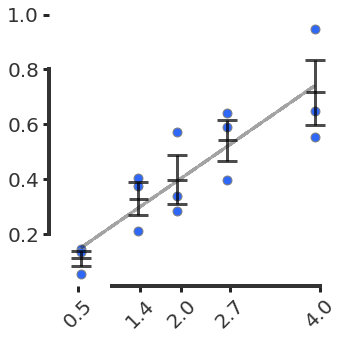

In [272]:
sns.set(font_scale=2.5)
sns.set(font="Arial")
sns.set_style("ticks")
sns.despine()
sns.set_palette("Set2")
var="mean tnr"
fig=plt.figure(figsize=(5,5))
g=sns.scatterplot(x="mean size int in bin overall micronsq",y="mean tnr",
                data=dfmeans,s=80,color="#2F67F8",linewidth=1,edgecolor='grey')

plt.errorbar(x = dfmeans["mean size int in bin overall micronsq"].unique()
,
             y=[dfmeans[dfmeans["bin number"]==0][var].mean(),
                dfmeans[dfmeans["bin number"]==1][var].mean(),
                dfmeans[dfmeans["bin number"]==2][var].mean(),
                dfmeans[dfmeans["bin number"]==3][var].mean(),
                dfmeans[dfmeans["bin number"]==4][var].mean()],
             yerr=[dfmeans[dfmeans["bin number"]==0][var].sem(),
                   dfmeans[dfmeans["bin number"]==1][var].sem(),
                   dfmeans[dfmeans["bin number"]==2][var].sem(),
                   dfmeans[dfmeans["bin number"]==3][var].sem(),
                   dfmeans[dfmeans["bin number"]==4][var].sem()],
             xerr=None,ecolor='black',fmt='none',capsize=10,linewidth=3,capthick=3,alpha=.7,)

plt.errorbar(x = dfmeans["mean size int in bin overall micronsq"].unique()
,
             y=[dfmeans[dfmeans["bin number"]==0][var].mean(),
                dfmeans[dfmeans["bin number"]==1][var].mean(),
                dfmeans[dfmeans["bin number"]==2][var].mean(),
                dfmeans[dfmeans["bin number"]==3][var].mean(),
                dfmeans[dfmeans["bin number"]==4][var].mean()],
             yerr=None,
             xerr=[.14,.14,.14,.14,.14],ecolor='black',fmt='none',capsize=0,linewidth=3,capthick=3,alpha=.7,)


plt.rcParams['font.sans-serif'] = 'Helvetica'
g.grid(False)
#plt.ylim([0.6,1.41])
#plt.xlim([0.3,2.2])

#fit linear curve
x=dfmeans["mean size int in bin overall micronsq"]
y=dfmeans["mean tnr"]
m,b = np.polyfit(x, y, 1) 
plt.plot( x, m*x+b, 'k',linestyle='dashed',alpha=.4,linewidth=3) 


#change pixel count to nm2
#scale_x=1/.4
#ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_x))
#g.xaxis.set_major_formatter(ticks_x)


#formatting
g.xaxis.set_tick_params(width=3)
g.yaxis.set_tick_params(width=3)
for axis in ['top','bottom','left','right']:
  g.spines[axis].set_linewidth(4)
  g.spines[axis].set_color('#333333')
  g.spines[axis].set_alpha(1)
offsets={"left":10,"bottom":0}
trims={"left":False,"bottom":False,"right":False}
sns.despine(ax=g,right=True,top=True,bottom=False,trim=trims,offset=offsets)
g.set_ylabel('')
g.set_xlabel('')
plt.yticks([0.2,0.4,0.6,0.8,1],color='#333333',size=20)
plt.xticks([0.5,1.4,2,2.7,4],color='#333333',size=20,rotation=45)

diri="/Volumes/Macintosh HD/Users/taldankovich/Downloads/figures/"
fig.savefig(diri+'supp3_tnrsizecorr.svg', bbox_inches='tight', format='svg')

In [285]:
from pydoc import help
from scipy.stats.stats import pearsonr
[pearson, pval]=pearsonr(dfmeans["mean tnr"],dfmeans["mean size int in bin overall"])
print(str(pearson**2))
print(pval)

0.7506883817266187
2.9412245988701806e-05


## Find representative spots

## Number of synapses analyzed

In [282]:
for i in range(0,5):
    dfcount=dfnew[(dfnew[synapse_bin_type].astype(int)==binno)]
    print(len(dfcount))

288
288
288
288
288


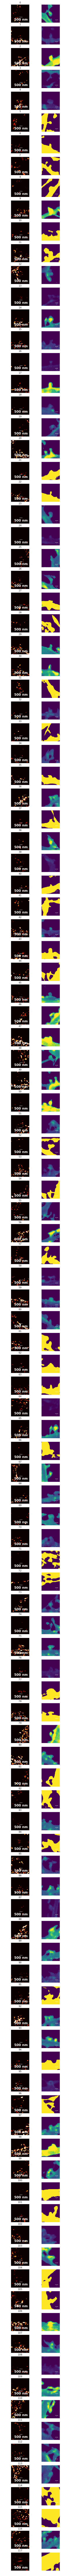

In [277]:
binno=4
synapse_bin_type="Synapse mean size ordinal bin"

dfnewi=df2

df2plot=dfnew[(dfnew["classification"]==1)
    &(dfnew[synapse_bin_type].astype(int)==binno)]
df2plot=df2plot.reset_index()


def rebin(arr, new_shape):
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
             new_shape[1], arr.shape[1] // new_shape[1])
    return arr.reshape(shape).mean(-1).mean(1)

fig=plt.figure(figsize=(5,400))
num=1
for i in range(0,len(df2plot)):
    randomno=np.random.randint(1,len(df2plot))
    ecm=df2plot["ecm intensity sted, bg subtracted"][i]
    #ecm=rebin(ecm,[50,50])
    synapse=df2plot["dio spot aligned"][i]
    #synapse=rebin(synapse,[50,50])
    name=df2plot["spots classification filename"][i]
    fig.add_subplot(200,2,num)
    plt.axis('off')
    
    plt.imshow(ecm,cmap='hot',
               vmin=0.95*np.min(dfnew["ecm intensity sted, bg subtracted"].mean()),
               vmax=25*np.max(dfnew["ecm intensity sted, bg subtracted"].mean()))
    scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
    plt.gca().add_artist(scalebar)
    plt.axis('off')
    plt.ylabel('Bin: '+str(i))
    plt.title(i)
    fig.add_subplot(200,2,num+1)
    plt.imshow(synapse,
               cmap='viridis',
               vmin=0.95*np.min(dfnew["dio spot aligned"].mean()),
               vmax=np.max(dfnew["dio spot aligned"].mean()))
    numbersynapses=len(df2plot["dio spot aligned"])
    

    scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':0,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
    plt.gca().add_artist(scalebar)
    plt.axis('off')
    num+=2

## plot spots nicely

In [265]:
maxim=0.
for i in range(0,len(dfnew)):
    maxi=dfnew['ecm intensity sted, bg subtracted'][i].max()
    if maxi>maxim:
        maxim=maxi

In [266]:
maxim=0.
for i in range(0,len(dfnew)):
    maxi=dfnew['dio spot aligned'][i].max()
    if maxi>maxim:
        maxim=maxi
print(maxim)

389.0


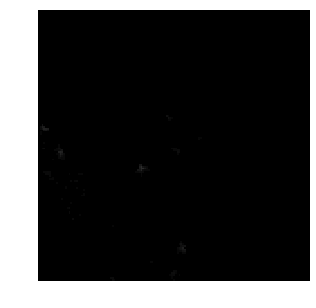

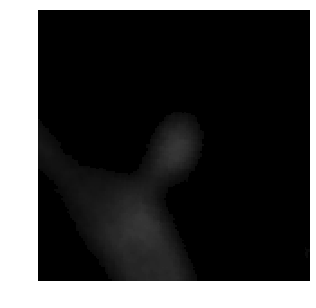

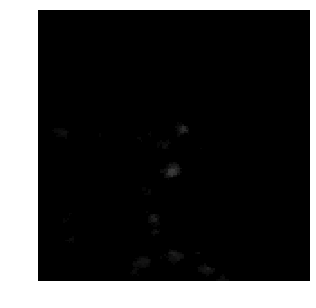

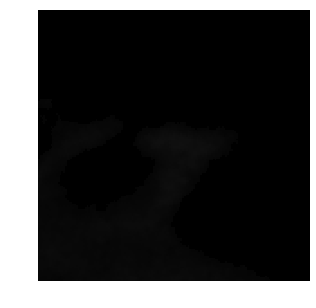

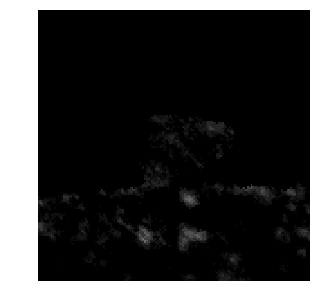

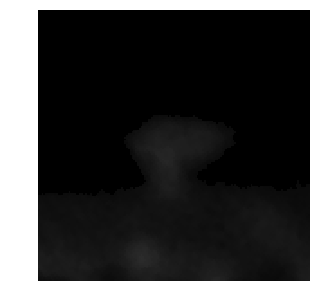

In [279]:
diri="/Volumes/Macintosh HD/Users/taldankovich/Downloads/figures/"

import image

dfnewi=dfnew[(dfnew["classification"]==1)]

df2plot_bin0=dfnewi[dfnewi[synapse_bin_type].astype(int)==2]
df2plot_bin0=df2plot_bin0.reset_index()

df2plot_bin2=dfnewi[dfnewi[synapse_bin_type].astype(int)==3]
df2plot_bin2=df2plot_bin2.reset_index()

df2plot_bin4=dfnewi[dfnewi[synapse_bin_type].astype(int)==4]
df2plot_bin4=df2plot_bin4.reset_index()


spot_0=47#13#552 #8
spot_2=48#7#682 #549
spot_4=75#52# 849

spots=[spot_0,spot_2,spot_4]

vmin=0
vmax=183.11132006052367

vminsyn=0
vmaxsyn=389

count=0
for spot in spots:
    if count==0:
        df2plot=df2plot_bin0
    if count==1:
        df2plot=df2plot_bin2
    if count==2:
        df2plot=df2plot_bin4
    ecm=df2plot["ecm intensity sted, bg subtracted"][spot]
    synapse=df2plot["dio spot aligned"][spot]
    #if count==2:
    #    ecm=np.rot90(ecm)
    #    synapse=np.rot90(synapse)
    
    
    fig_ecm=plt.figure(figsize=(5,5))
    plt.axis('off')
    plt.imshow(ecm,cmap='gray',
               vmin=vmin,
               vmax=vmax)
    
    scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':0,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
    #plt.gca().add_artist(scalebar)
    
    plt.imsave(arr=ecm,cmap='gray',
               vmin=vmin,
               vmax=vmax,fname=diri+'supp3_tnrdiosize_ecm_bin_'+str(count)+'.tiff')
    
    
    fig_syn=plt.figure(figsize=(5,5))
    plt.imshow(synapse,
               cmap='gray',
               vmin=vminsyn,
               vmax=vmaxsyn)
    
    scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':0,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
    #plt.gca().add_artist(scalebar)
    plt.axis('off')
    plt.imsave(arr=synapse,cmap='gray',
               vmin=vmin,
               vmax=vmax,fname=diri+'supp3_tnrdiosize_dio_bin_'+str(count)+'.tiff')
    
    count+=1
    
    



## Backup dataframe

In [286]:
df2.to_pickle(expdir+'df2_dioanalysis.pkl')

OSError: [Errno 22] Invalid argument